<a href="https://colab.research.google.com/github/VikramO/Roswell-Park-s-DBBR-Cancer-Patient-Survival-Prediction/blob/main/AIMDatathon_StageProgression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import os

train = pd.read_csv('Tumor Information_train.csv')
test = pd.read_csv('Tumor Information_test.csv')

train.columns = map(str.lower, train.columns)
test.columns = map(str.lower, test.columns)

file_list = os.listdir()
file_list.remove('Tumor Information_train.csv')
file_list.remove('Tumor Information_test.csv')
file_list.remove('DBBR Questionnaire Data Dictionary.csv')

print(file_list)

for data in file_list:
  train = train.merge(pd.read_csv(data).rename(columns=str.lower), on='qbarcode', how='left')
  test = test.merge(pd.read_csv(data).rename(columns=str.lower), on='qbarcode', how='left')

In [ ]:
all_data = pd.concat([train, test])

from sklearn import preprocessing

cols = [col for col in all_data.columns if col not in ['grade', 'qbarcode']]

types = all_data.dtypes
cat_columns = [t[0] for t in types.iteritems() if ((t[1] not in ['int64', 'float64']))]

print('Label encoding categorical columns:', cat_columns)
lbl = preprocessing.LabelEncoder()
for col in cat_columns:
    all_data[col] = lbl.fit_transform(all_data[col].astype(str))

all_data = all_data.fillna(all_data.mode().iloc[0])
all_data = all_data.drop(columns=['grade'])

train_processed_data = all_data.iloc[:len(dftrain)]
test_processed_data = all_data.iloc[len(dftrain):]

#grade 3 encoding = 2
#grade 2 encoding = 1
#grade 1 encoding = 0
#prostate encoding = 85

print(all_data['primarysite'].value_counts())
prostate_data = all_data.loc[all_data['primarysite'] == 85]
print(prostate_data['grade'].value_counts())
prostate_data = prostate_data.loc[prostate_data['grade'] != 0]
prostate_data['grade'] = prostate_data['grade'] - 1
print(prostate_data.head())

prostate_cols = [col for col in all_data.columns if col not in ['grade', 'qbarcode']]

Label encoding categorical columns: ['primarysite', 'histology', 'grade', 'country', 'ethnoth', 'raceoth', 'insuroth', 'actloth', 'acetoth', 'ibproth', 'nprxoth', 'antioth', 'cox2oth', 'antaoth1', 'antaoth2', 'acdroth', 'acdooth', 'prdnoth1', 'prdnoth2', 'tmoxoth1', 'tmoxoth2', 'ostoth1', 'ostoth2', 'viagoth1', 'viagoth2', 'hytroth1', 'hytroth2', 'flmxoth1', 'flmxoth2', 'prscoth1', 'ditroth1', 'rx1o', 'rx1oth1', 'rx1oth2', 'rx2o', 'rx2oth1', 'rx2oth2', 'brnd1', 'brnd2', 'occup', 'ocx1', 'ocx1std', 'ocx2', 'ocx2std', 'ocx1c', 'ocx1cstd', 'ocx2c', 'ocx2cstd', 'cncr1', 'cncr1std', 'cncr2', 'cncr2std', 'cncr3', 'cncr3std', 'cncr4', 'cncr4std', 'hep1', 'hep2']
85    371
23    302
21    186
60    121
22    101
     ... 
71      1
72      1
74      1
76      1
63      1
Name: primarysite, Length: 127, dtype: int64
2    223
1    147
0      1
Name: grade, dtype: int64
    qbarcode  primarysite  histology  ...      wt30kg      wt45kg      wt60kg
0       1454           85          7  ...   92.986

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

cols = [col for col in train_processed_data.columns if col not in ['grade', 'qbarcode']]

train = prostate_data[prostate_cols].values
labels = prostate_data['grade'].values

x_train, x_val, y_train, y_val = train_test_split(train, labels, test_size=0.2, random_state=42)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: Degrees of freedom <= 0 for slice
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwarg

In [ ]:
bst = xgb.XGBClassifier(max_depth=4, n_estimators=150, learning_rate=0.3, objective='reg:logistic')
bst.fit(x_train, y_train)
print(bst.score(x_val, y_val))
y_hat = bst.predict(x_val)
print(roc_auc_score(y_val, y_hat))

0.6621621621621622
0.6359940872135994


array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0])

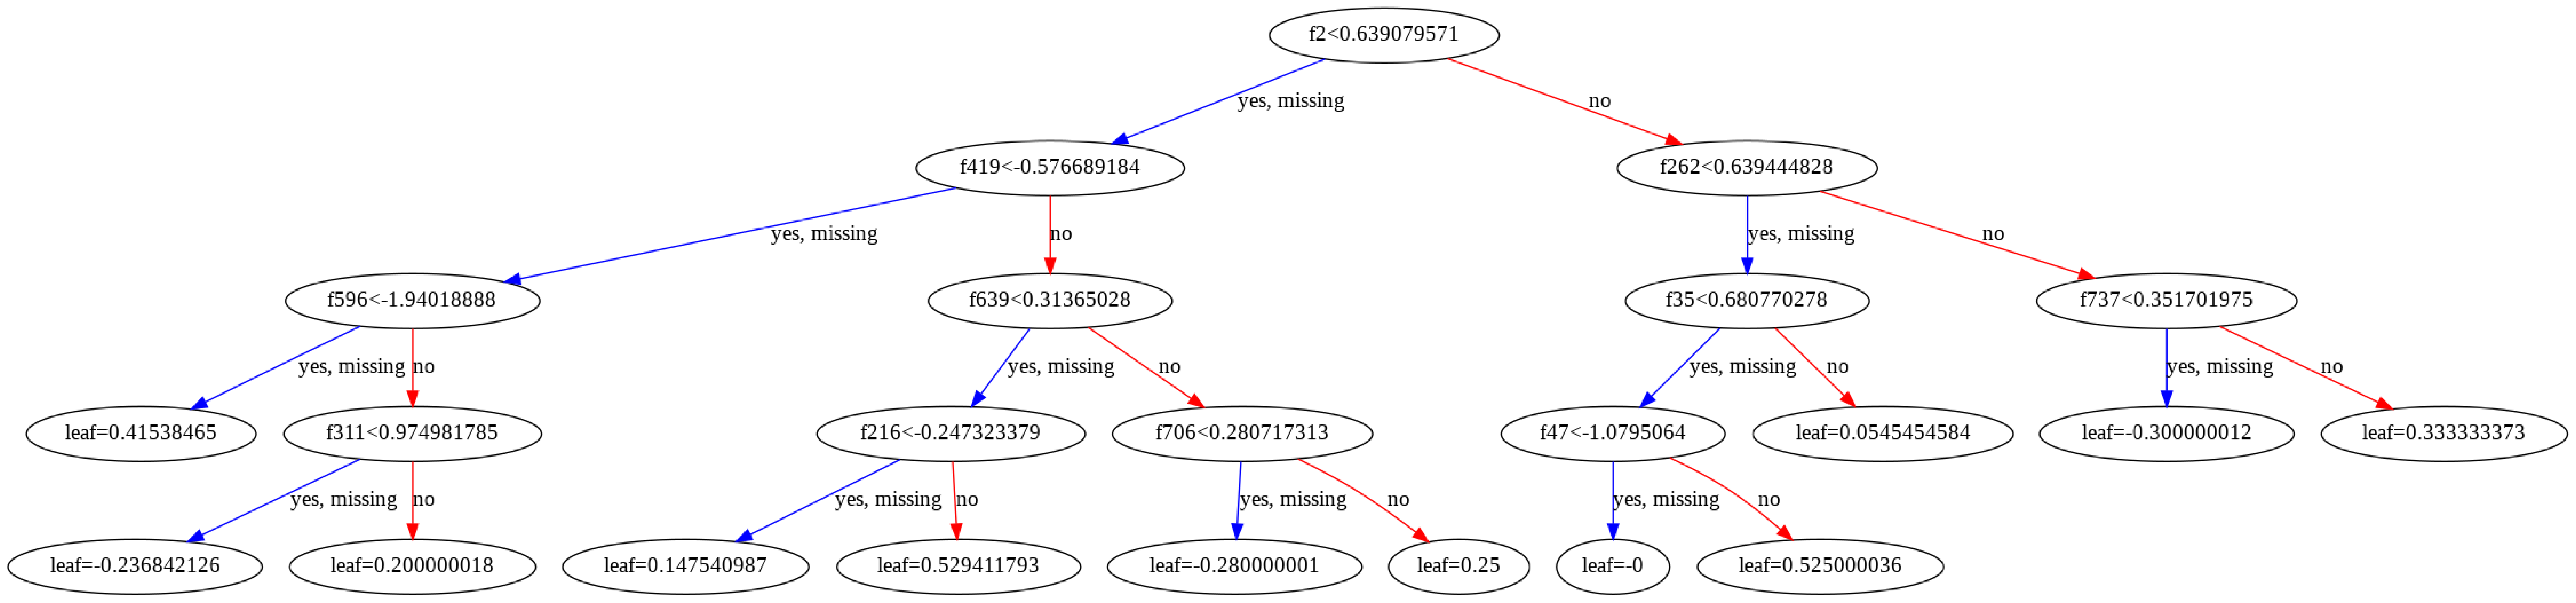

In [ ]:

import matplotlib
import matplotlib.pyplot as plt
from xgboost import plot_tree
plot_tree(bst)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

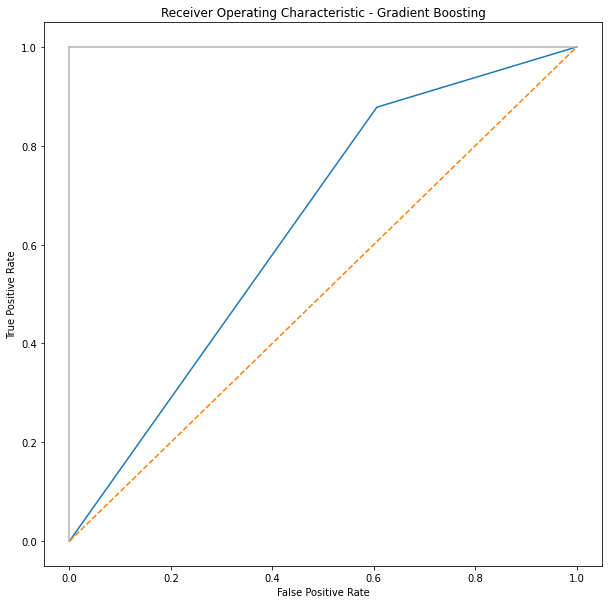

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_val, y_hat)

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Gradient Boosting')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
test= test_processed_data[cols].values
predictions = bst.predict(test)

out_df = pd.DataFrame(
        {"qbarcode": test_processed_data.qbarcode.values,
         "CancerStage": predictions
        }
    )

print(out_df.head(20))